In [1]:
install.packages("remotes")
remotes::install_github("silkeszy/Pomona")
# caret and reshape2 I had to install via conda
pacman::p_load(readr,dplyr,tibble,ranger,mlr,tuneRanger,tidyr,
               data.table,ggplot2,vegan,Pomona,caret,reshape2,cowplot,tidyverse,viridis)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Skipping install of 'Pomona' from a github remote, the SHA1 (2283f732) has not changed since last install.
  Use `force = TRUE` to force installation



In [2]:
eukaryotic_taxonomy = data.frame(fread(file.path("..","..","input","2021-02-estimated_taxonomy.csv"))) %>%
            dplyr::filter(taxonomy != '-;-;-;-;-;-')
prokaryotic_taxonomy = data.frame(fread(file.path("..","..","input","for_aik_taxonomy.csv")))

set.seed(1)

# functions ----------------------------

# Author: Taylor Reiter ----------------
ggplotConfusionMatrix <- function(m, plot_title = NULL){
  library(ggplot2)
  library(scales)
  library(tidyr)
  mycaption <- paste("Accuracy", percent_format()(m$overall[1]),
                     "Kappa", percent_format()(m$overall[2]))
  #mycaption <- paste("Accuracy", percent_format()(m$overall[1]))
  p <-
    ggplot(data = as.data.frame(m$table) ,
           aes(x = Reference, y = Prediction)) +
    geom_tile(aes(fill = log(Freq)), colour = "white") +
    scale_fill_gradient(low = "white", high = "steelblue") +
    geom_text(aes(x = Reference, y = Prediction, label = Freq)) +
    theme_minimal() +
    theme(legend.position = "none", 
          text = element_text(size = 9),
          axis.text.x = element_text(angle = 30, vjust = 1),
          axis.text = element_text(size = 7),
          plot.title = element_text(hjust = 0.5)) +
    labs(caption = mycaption, title = plot_title)
  return(p)
}

# Author: Taylor Reiter ----------------
evaluate_model <- function(optimal_ranger, data, reference_class, plt_title) {
  library(ranger)
  library(readr)
  
  # calculate prediction accuracy
  pred <- predict(optimal_ranger, data)
  pred_tab <- table(observed = reference_class, predicted = pred$predictions)
  print(pred_tab)
  
  # calculate performance
  performance <- sum(diag(pred_tab)) / sum(pred_tab)
  print(paste0("ACCURACY = ", performance))
  
  # plot pretty confusion matrix
  cm <- confusionMatrix(data = pred$predictions, reference = reference_class)
  ggplotConfusionMatrix(cm, plot_title = plt_title)
  # ggsave(filename = confusion_pdf, plot = plt, scale = 1, width = 6, height = 4, dpi = 300)
}

#' Copy the taxonomy and return whether a eukaryote or a prokaryote
#' and its taxonomy string.
# Author: Arianna Krinos ----------------
get_euk_prok <- function(genome_names) {
    modified_df = data.frame(Genome = genome_names) %>% 
        dplyr::left_join(eukaryotic_taxonomy, by = c("Genome" = "mag")) %>%
        dplyr::left_join(prokaryotic_taxonomy, by = "Genome") %>%
        dplyr::select(Genome,taxonomy,classification)
    modified_df = modified_df %>% 
        dplyr::mutate(taxonomy = replace_na(taxonomy, ""),
                      classification = replace_na(classification, "")) %>%
        mutate(taxonomy = replace(taxonomy, classification != "", "")) %>%
        dplyr::mutate(no_classification = ifelse(((taxonomy == "") | 
                                                  (taxonomy == '-;-;-;-;-;-')) & 
                                                 (classification == ""), 
                                                 "none", "")) %>%
        pivot_longer(
           cols = c("classification","no_classification","taxonomy"),
           names_to = "classification_type",
           values_to = "classification"
        ) %>% 
        dplyr::filter(classification != "") %>%
        dplyr::filter(classification != '-;-;-;-;-;-') %>%
        dplyr::mutate(EukOrProk = factor(classification_type)) 
    modified_df$EukOrProk = as.character(modified_df$EukOrProk)
    modified_df$EukOrProk[modified_df$EukOrProk == "taxonomy"] = "euk"
    modified_df$EukOrProk[modified_df$EukOrProk == "classification"] = "prok"
    modified_df$EukOrProk[modified_df$EukOrProk == "no_classification"] = "unclass"
    return(modified_df)
}

# Author: Arianna Krinos ----------------
select_KOs <- function(mmetsp_allfeatures,selected_kos) {
    # Put the KO annotations with the MMETSP KO data
    ko_merged = mmetsp_allfeatures %>% 
                tidyr::pivot_longer(cols = (starts_with("K") & !(starts_with("Ke"))),
                                    names_to="KEGG_ID_NUM") %>%
                dplyr::filter(KEGG_ID_NUM %in% selected_kos)
    ko_merged = ko_merged %>% 
        dplyr::distinct(KEGG_ID_NUM,Source_ID,.keep_all=TRUE) %>%
        tidyr::pivot_wider(names_from =KEGG_ID_NUM,values_from=value,id_cols=Source_ID,values_fn=mean)
    return(ko_merged)
}

# Author: Arianna Krinos ----------------
generate_scores_selected_features <- function(mmetsp_allfeatures,selected_kos) {
    # Put the KO annotations with the MMETSP KO data
    ko_merged = mmetsp_allfeatures %>% 
                tidyr::pivot_longer(cols = (starts_with("K") & !(starts_with("Ke"))),
                                    names_to="KEGG_ID_NUM") %>%
                dplyr::filter(KEGG_ID_NUM %in% selected_kos)
    
    # Truncate important columns in matrix
    ko_merged_trunc = ko_merged[c("Source_ID","Trophic.mode","KEGG_ID_NUM","value")]
    
    # Sum KO results
    ko_summed = ko_merged_trunc %>%
                dplyr::group_by(Trophic.mode,KEGG_ID_NUM) %>%
                dplyr::summarize(summed = sum(value))

    # Get total counts of KOs
    ko_counted = ko_merged_trunc %>%
                dplyr::group_by(Trophic.mode,KEGG_ID_NUM) %>%
                dplyr::summarize(total = n())
    
    # Filter out KOs below a certain level of consensus
    merged_results = ko_summed %>% dplyr::inner_join(ko_counted, by = c("KEGG_ID_NUM","Trophic.mode")) %>%
                        dplyr::mutate(Ratio = summed / total) %>%
                        dplyr::mutate(ProbSuccess = Ratio) %>%
                        dplyr::rename("Predicted.trophic.mode" = "Trophic.mode") %>%
                        dplyr::distinct(Predicted.trophic.mode,KEGG_ID_NUM,.keep_all = TRUE)

    return(merged_results)
}

# input the vector of probabilities for each of the KEGGs generated from the MMETSP
# Author: Arianna Krinos ----------------
generate_point_values <- function(vect_probabilities) {
    votes_ret = data.frame("Prob" = vect_probabilities) %>%
            dplyr::mutate(votes = case_when(Prob < 0.5 ~ (-(0.5-Prob)),
                                            Prob >= 0.5 ~ Prob))
    return(votes_ret$votes)
}

# Author: Arianna Krinos ----------------
sum_up_votes <- function(vect_binary_values, votes_vect) {
    votes_summed_df = data.frame("Binary" = vect_binary_values,
                                 "Votes" = votes_vect)
    votes_summed_df$ModVote = votes_summed_df$Votes
    votes_summed_df$ModVote[which(votes_summed_df$Binary == 0)] = -votes_summed_df$Vote[
        which(votes_summed_df$Binary == 0)]
    return(floor(sum(votes_summed_df$ModVote)))
}

# Author: Arianna Krinos ----------------
classify_points_binom <- function(KOmatrix_topredict, model_matrix, id_col_name) {
    # Convert sample KO matrix to long format
    KOmatrix_topredict["Source_ID"] = KOmatrix_topredict[id_col_name]
    formatted_KOmatrix_long = KOmatrix_topredict %>% 
                tidyr::pivot_longer(cols = (starts_with("K") & !(starts_with("Ke"))),
                                    names_to="KEGG_ID_NUM")
    
    # Merge the matrix of model scores with the test data
    formatted_KOmatrix_topredict = model_matrix %>% 
                                   dplyr::select(KEGG_ID_NUM,Predicted.trophic.mode,ProbSuccess) %>%
                                   dplyr::inner_join(formatted_KOmatrix_long %>% 
                                                     dplyr::select(KEGG_ID_NUM,value,Source_ID)
                                                     , by = "KEGG_ID_NUM") %>%
                                   arrange(KEGG_ID_NUM)
    model_matrix = model_matrix %>% arrange(KEGG_ID_NUM)
    
    formatted_KOmatrix_topredict["Votes"] = generate_point_values(formatted_KOmatrix_topredict$ProbSuccess)
    
    vote_matrix = formatted_KOmatrix_topredict %>%
        dplyr::group_by(Source_ID,Predicted.trophic.mode) %>%
        group_modify(~ {
         sum_up_votes(.x$value, .x$Votes) %>%
         tibble::enframe(value = "Score")
        })
    
    results_matrix = vote_matrix %>% 
            tidyr::pivot_wider(names_from = Predicted.trophic.mode,
                               values_from = Score, id_cols = "Source_ID")
    
    # Generate point vectors for each trophic mode.
    heterotroph_points_vect = generate_point_values(as.numeric((model_matrix %>% 
                                    dplyr::filter(Predicted.trophic.mode == "Heterotroph"))$ProbSuccess))
    mixotroph_points_vect = generate_point_values(as.numeric((model_matrix %>% 
                                    dplyr::filter(Predicted.trophic.mode == "Mixotroph"))$ProbSuccess))
    phototroph_points_vect = generate_point_values(as.numeric((model_matrix %>% 
                                    dplyr::filter(Predicted.trophic.mode == "Phototroph"))$ProbSuccess))
    
    results_matrix = results_matrix %>%
        dplyr::mutate(HeterotrophyScore = case_when(
                                  (Mixotroph - max(Heterotroph,Phototroph)) < 50 ~ sign(Heterotroph-Phototroph)*
                                                  (sqrt((Heterotroph-Phototroph)^2)),
                                  Mixotroph > 0 ~ sign(Heterotroph-Phototroph)*
                                                  (sqrt((Heterotroph-Phototroph)^2)) / Mixotroph,
            #^(1/Mixotroph),
                                                  #-sign(Heterotroph-Phototroph) * Mixotroph,
                                  Mixotroph <= 0 ~ sign(Heterotroph-Phototroph)*
                                                    sqrt((Heterotroph-Phototroph)^2)
                                )) %>%
        dplyr::mutate(Predicted.trophic.mode = case_when(
                                HeterotrophyScore > 5 ~ "Heterotroph",
                                HeterotrophyScore < -5 ~ "Phototroph",
                                TRUE ~ "Mixotroph"
                                ))
    predicted_modes_byindex = results_matrix[c("Source_ID","HeterotrophyScore","Predicted.trophic.mode")]
    predicted_modes_byscore = vote_matrix %>% 
                                group_by(Source_ID) %>%
                                filter(Score == max(Score)) 
    return(list(vote_matrix, predicted_modes_byindex, predicted_modes_byscore))
}

ERROR: Error in fread(file.path("..", "..", "input", "2021-02-estimated_taxonomy.csv")): File '../../input/2021-02-estimated_taxonomy.csv' does not exist or is non-readable. getwd()=='/vortexfs1/omics/alexander/akrinos/2021-03_Tara/2021-TOPAZ-MAG-Figures/notebooks'


In [ ]:
##### READ IN REQUIRED DATA #####
## CANDIDATE MAGS ##
kegg_mag_annotation = read.csv(file.path("..","..","input","MAG_keggannot.csv"))
new_columns = c("MAG", colnames(kegg_mag_annotation)[2:length(colnames(kegg_mag_annotation))])
colnames(kegg_mag_annotation) = new_columns

## MMETSP INPUT INFO ##
kegg_mmetsp_annotation = read.csv(file.path("..","..","input","MMETSP_keggannot.csv"))
new_columns = c("Source_ID", colnames(kegg_mmetsp_annotation)[2:length(colnames(kegg_mmetsp_annotation))])
colnames(kegg_mmetsp_annotation) = new_columns

# These MAGs have low completeness per Harriet
suspicious_MAGs = c("MMETSP1147","MMETSP1148","MMETSP0018","MMETSP0252","MMETSP0924","MMETSP1019",
                   "MMETSP0451","MMETSP0225","MMETSP0210","MMETSP0186","MMETSP0251","MMETSP1018",
                   "MMETSP0398","MMETSP0132","MMETSP1317","MMETSP0229","MMETSP0196","MMETSP0798",
                   "MMETSP0922","MMETSP0044","MMETSP0347","MMETSP0223")
kegg_mmetsp_annotation = kegg_mmetsp_annotation %>% dplyr::filter(!(Source_ID %in% suspicious_MAGs))

## MMETSP TROPHY ANNOTATIONS ##
mmetsp_trophy_annotation = read.csv(file.path("..","..","input","2020-12-mmetsp-trophy-skh.csv"))

## KO INFORMATION ##
ko_conversion = read.csv(file.path("..","..","input","ko_koID_to_metaD.txt"), sep = "\t")
ko_conversion = ko_conversion %>%
                tidyr::separate(briteTopL_pathMapID_class_pathway_geneName_geneDesc,
                                sep = ";", 
                                into = strsplit("briteTopL_pathMapID_class_pathway_geneName_geneDesc","_")[[1]]) %>%
                tidyr::separate(koID, sep = ":", into = c("KO","IDnum")) %>%
                dplyr::distinct(IDnum, .keep_all = TRUE)
ko_conversion$KEGG_ID_NUM = 0
for (index_curr in c(1:length(ko_conversion$KEGG_ID_NUM))) {
    curr_split = strsplit(ko_conversion$IDnum[index_curr],"K")[[1]][2]
    ko_conversion$KEGG_ID_NUM[index_curr] = as.numeric(curr_split)
}

## EUKPROT INPUTS ##
kegg_euk_prot = data.frame(fread(file.path("/vortexfs1","omics","alexander","share","EukProt_kegganot.csv")))
kegg_euk_prot["sumVar"] = rowSums(kegg_euk_prot %>% dplyr::select(starts_with("K")))
kegg_euk_prot_complete = kegg_euk_prot %>%
                             dplyr::filter(sumVar > 500) %>%
                             tidyr::separate(V1, into = c("EPID","Genus","Species",
                                                          "Species2","Species3"), sep = "_") %>%
                             unite("Tax", c("Genus","Species","Species2",
                                            "Species3"), remove = TRUE, na.rm = TRUE)

euk_prot_trophy = data.frame(fread(file.path("..","..","input","eukprot_trophy.csv")))
euk_prot_trophy$Full_Name = euk_prot_trophy$Name_to_Use
for (id in kegg_euk_prot_complete$Tax) {
    euk_prot_trophy$Name_to_Use[which(grepl(id,euk_prot_trophy$Name_to_Use))] = id
}
merged_annotations = euk_prot_trophy %>% dplyr::select(c("Name_to_Use","Taxonomy_UniEuk","Keep","Trophic.mode")) %>%
                        dplyr::left_join(kegg_euk_prot_complete, by = c("Name_to_Use" = "Tax"))
merged_annotations_eukprot = merged_annotations %>% dplyr::filter(Keep == 1) %>%
                                tidyr::drop_na(EPID)
# Convert EukProt annotations to features
kegg_eukprok_annotation = merged_annotations_eukprot %>% dplyr::select(starts_with('K'))

mmetsp_allfeatures = kegg_mmetsp_annotation %>%
                         dplyr::inner_join(mmetsp_trophy_annotation,by = c("Source_ID"="Source_ID"))
eukprot_withtax = merged_annotations_eukprot %>% tidyr::separate(Taxonomy_UniEuk,sep=";",
                                                    into=c("Domain","Supergroup","MajorClade","Clade",
                                                           "Division","Class"))
all_tax_info = mmetsp_allfeatures %>% dplyr::bind_rows(eukprot_withtax)

In [4]:
all_tax_info = mmetsp_allfeatures %>% dplyr::bind_rows(eukprot_withtax)

In [ ]:
##### GENERATE TEST SET #####
# Generate a test set from randomly selected eukprot+mmetsp
k_cols = colnames(mmetsp_allfeatures)[grepl("K",colnames(mmetsp_allfeatures))]
mmetsp_allfeatures_test = mmetsp_allfeatures[c("Source_ID","Trophic.mode",k_cols)]
k_cols = colnames(merged_annotations_eukprot)[grepl("K",colnames(merged_annotations_eukprot))]
eukprot_allfeatures_test = merged_annotations_eukprot[c("Name_to_Use","Trophic.mode",k_cols)]
eukprot_allfeatures_test = eukprot_allfeatures_test %>% 
                        rename(Source_ID = "Name_to_Use")
all_test_data = eukprot_allfeatures_test %>% dplyr::bind_rows(mmetsp_allfeatures_test)

train_rows = all_test_data %>% sample_frac(0.75)
test_rows = all_test_data %>% dplyr::filter(!(Source_ID %in% train_rows$Source_ID))

write.csv(test_rows,paste0("test_set_",as.character(Sys.Date()),".csv"))
write.csv(train_rows,paste0("train_set_",as.character(Sys.Date()),".csv"))

In [5]:
k_cols = colnames(mmetsp_allfeatures)[grepl("K",colnames(mmetsp_allfeatures))]
mmetsp_allfeatures_test = mmetsp_allfeatures[c("Source_ID","Trophic.mode",k_cols)]
k_cols = colnames(merged_annotations_eukprot)[grepl("K",colnames(merged_annotations_eukprot))]
eukprot_allfeatures_test = merged_annotations_eukprot[c("Name_to_Use","Trophic.mode",k_cols)]
eukprot_allfeatures_test = eukprot_allfeatures_test %>% 
                        rename(Source_ID = "Name_to_Use")
all_test_data = eukprot_allfeatures_test %>% dplyr::bind_rows(mmetsp_allfeatures_test)

In [4]:
test_rows = read.csv(file.path("..","tables","test_set_2021-03-06.csv"))
train_rows = read.csv(file.path("..","tables","train_set_2021-03-06.csv"))
vita = readRDS(file.path("..","data",paste0("vita_model_seed12021-03-06.RDS")))

In [ ]:
##### VARIABLE SELECTION #####
# var.sel.vita calculates p-values based on the empirical null distribution
# from non-positive VIMs as described in Janitza et al. (2015).
vita <- Pomona::var.sel.vita(x = train_rows %>% dplyr::select(starts_with("K") & !starts_with("Ke")), 
                     y = train_rows$Trophic.mode, p.t = 0.05,
                     ntree = 10000, mtry.prop = 0.2, nodesize.prop = 0.1,
                     no.threads = 3, method = "ranger", type = "classification")
saveRDS(vita, file.path("..","..","output",paste0("vita_model_seed1",as.character(Sys.Date()),".RDS")))

In [5]:
write.csv(data.frame("Selected KOs" = vita$var),file.path("..","tables","vita_selected_vars.csv"),row.names=FALSE)

In [6]:
vita_vars = read.csv(file.path("..","tables","vita_selected_vars.csv"))
vita_vars = vita_vars$Selected.KOs

In [8]:
ko_info_vita = ko_conversion %>% dplyr::filter(IDnum %in% vita_vars)

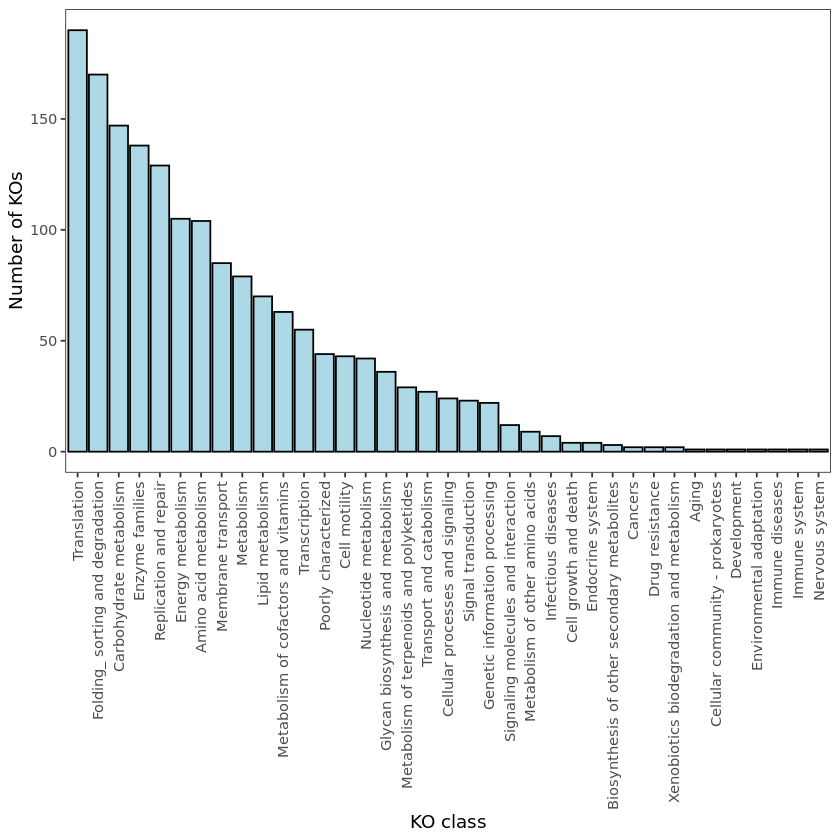

In [13]:
class_summary = ko_info_vita %>% dplyr::group_by(class) %>% dplyr::tally() %>%
  mutate(class = fct_reorder(class, desc(n)))
ggplot(class_summary) + 
    geom_bar(aes(x = class, y = n),stat="identity",fill = "light blue",col="black") + 
    theme_test() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    xlab("KO class") + ylab("Number of KOs")

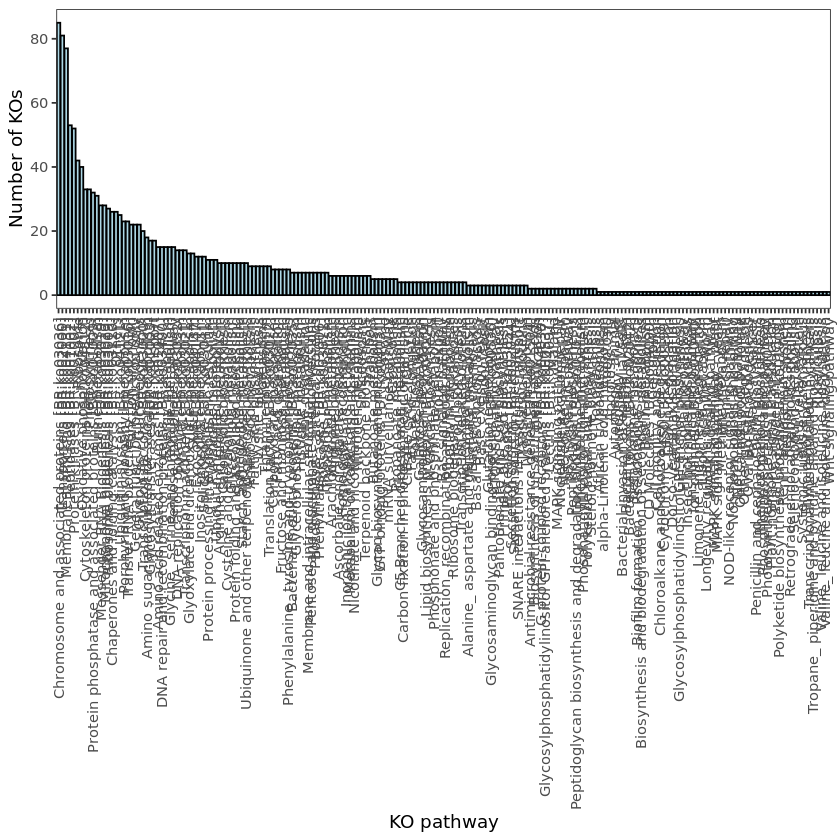

In [41]:
pathway_summary = ko_info_vita %>% dplyr::group_by(pathway) %>% dplyr::tally() %>%
  mutate(pathway = fct_reorder(pathway, desc(n)))
ggplot(pathway_summary) + 
    geom_bar(aes(x = pathway, y = n),stat="identity",fill = "light blue",col="black") + 
    theme_test() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    xlab("KO pathway") + ylab("Number of KOs")
ggsave("ko_pathways.png",width=20,height=8,units="in")

In [42]:
# Heterotrophy index model
training_scores = generate_scores_selected_features(train_rows, vita$var)

`summarise()` regrouping output by 'Trophic.mode' (override with `.groups` argument)

`summarise()` regrouping output by 'Trophic.mode' (override with `.groups` argument)



`summarise()` regrouping output by 'Predicted.trophic.mode' (override with `.groups` argument)



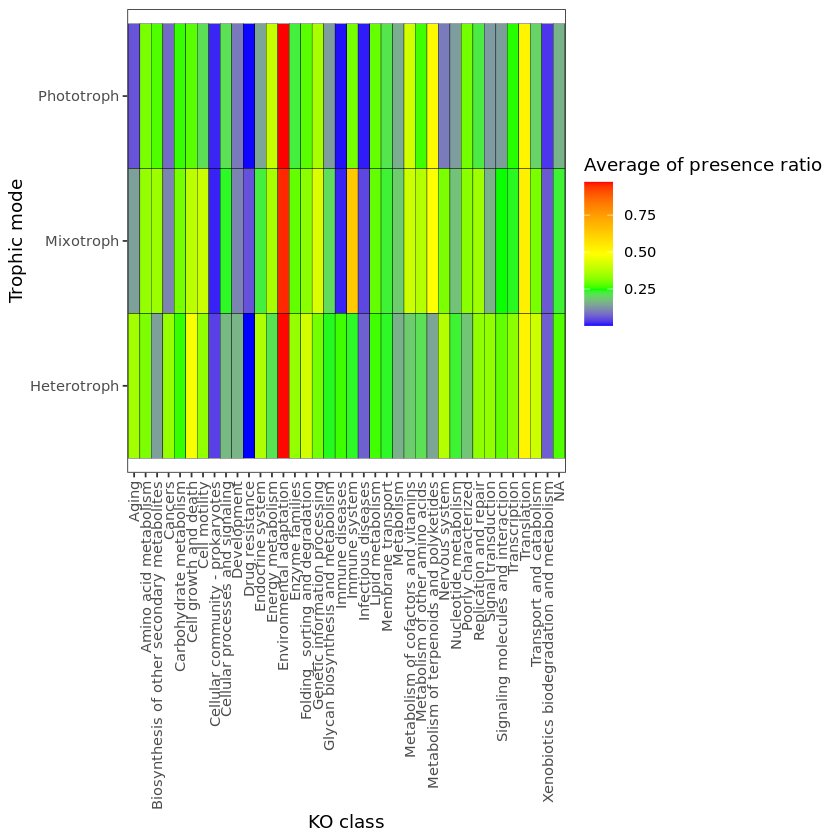

In [54]:
scores_with_KOs = training_scores %>% dplyr::left_join(ko_info_vita, by = c("KEGG_ID_NUM" = "IDnum"))
tm_kos = scores_with_KOs %>% dplyr::group_by(Predicted.trophic.mode,class) %>% 
            dplyr::summarize(MeanRatio = mean(Ratio))
ggplot(tm_kos) + geom_tile(aes(x = class, y = Predicted.trophic.mode, fill = MeanRatio),
                           col="black") + scale_fill_gradientn(colors=c("blue","green",
                                                                       "yellow","orange","red"),
                                                              name = "Average of presence ratio") +
    theme_test() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    xlab("KO class") + ylab("Trophic mode")

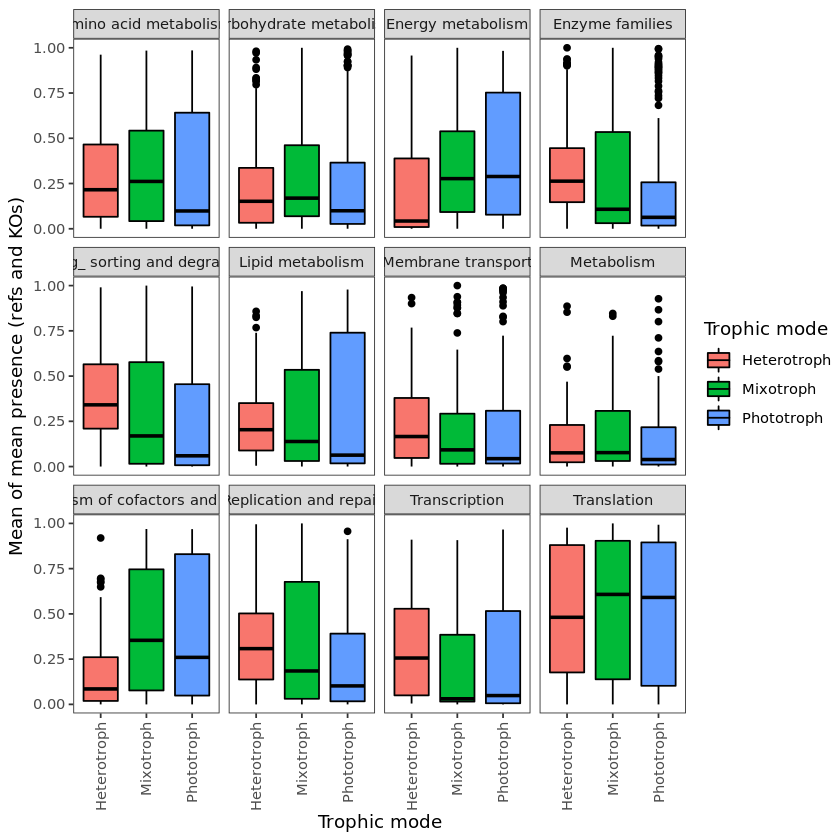

In [75]:
scores_with_KOs = training_scores %>% dplyr::left_join(ko_info_vita, by = c("KEGG_ID_NUM" = "IDnum"))
mean_frame = ko_info_vita %>% dplyr::group_by(class) %>% dplyr::tally() %>%
  mutate(class = fct_reorder(class, desc(n))) %>% dplyr::filter(n>50)

tm_kos = scores_with_KOs %>% dplyr::group_by(Predicted.trophic.mode,class) %>%
    dplyr::filter(class %in% mean_frame$class)
ggplot(tm_kos) + geom_boxplot(aes(x = Predicted.trophic.mode, y = Ratio, fill = Predicted.trophic.mode), 
                              #(x = class, y = Ratio, fill = Predicted.trophic.mode),
                           col="black") +
    theme_test() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    facet_wrap(~class) + 
    scale_fill_discrete(name = "Trophic mode") + 
    xlab("Trophic mode") + ylab("Mean of mean presence (refs and KOs)")

`summarise()` regrouping output by 'Predicted.trophic.mode', 'KEGG_ID_NUM' (override with `.groups` argument)



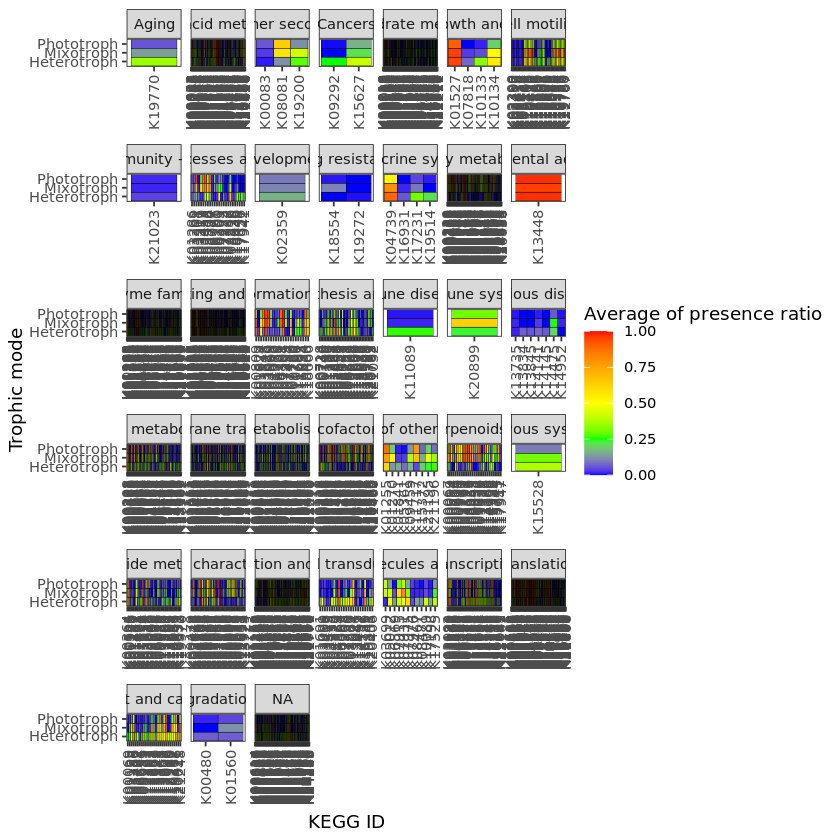

In [62]:
scores_with_KOs = training_scores %>% dplyr::left_join(ko_info_vita, by = c("KEGG_ID_NUM" = "IDnum"))
tm_kos = scores_with_KOs %>% dplyr::group_by(Predicted.trophic.mode,KEGG_ID_NUM,class) %>% 
            dplyr::summarize(MeanRatio = mean(Ratio))
ggplot(tm_kos) + geom_tile(aes(x = KEGG_ID_NUM, y = Predicted.trophic.mode, fill = MeanRatio),
                           col="black") + scale_fill_gradientn(colors=c("blue","green",
                                                                       "yellow","orange","red"),
                                                              name = "Average of presence ratio") +
    theme_test() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    facet_wrap(~class, scales = "free_x") + 
    xlab("KEGG ID") + ylab("Trophic mode")
ggsave("presence_ratio_facetted.png",width=25,height=8,units="in")

`summarise()` regrouping output by 'Predicted.trophic.mode', 'KEGG_ID_NUM' (override with `.groups` argument)



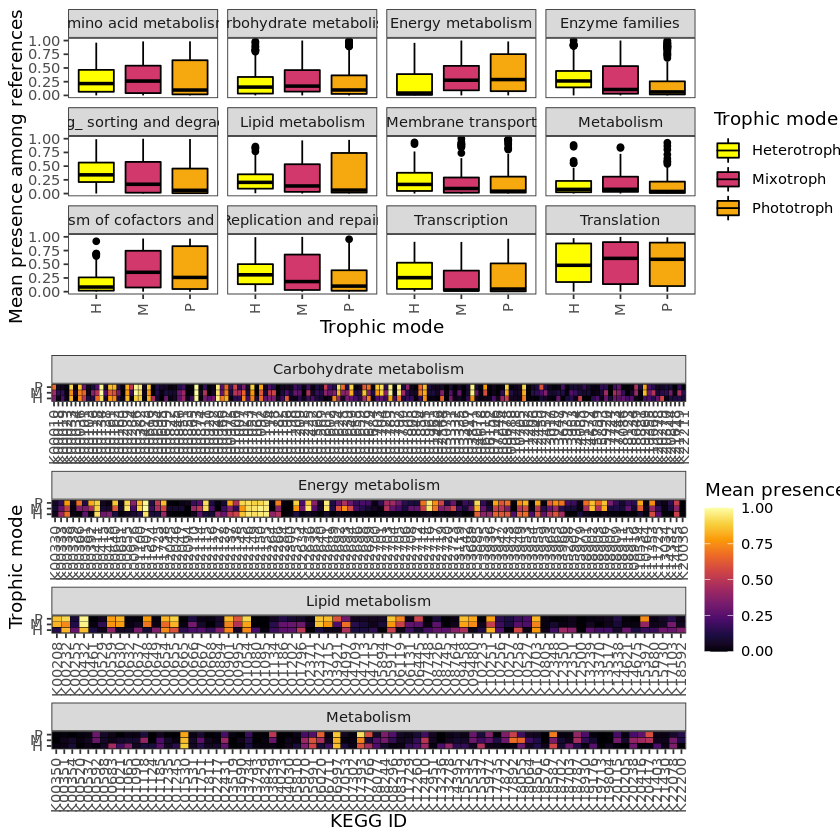

In [101]:
# create composite plot 
scores_with_KOs = training_scores %>% dplyr::left_join(ko_info_vita, by = c("KEGG_ID_NUM" = "IDnum"))
tm_kos = scores_with_KOs %>% dplyr::group_by(Predicted.trophic.mode,KEGG_ID_NUM,class) %>% 
            dplyr::summarize(MeanRatio = mean(Ratio)) %>% dplyr::filter(class %in% 
                                                                       c("Carbohydrate metabolism",
                                                                         "Energy metabolism",
                                                                         "Lipid metabolism",
                                                                         "Metabolism"))
heatmap = ggplot(tm_kos) + geom_tile(aes(x = KEGG_ID_NUM, y = Predicted.trophic.mode, fill = MeanRatio),
                           col="black") + 
    #scale_fill_viridis(name = "Mean presence") +
    #scale_fill_gradientn(colors=c("#F6A90F","#4A9C30","#522376"),name = "Mean presence") + 
    scale_fill_gradientn(colors=inferno(10),name = "Mean presence") + 

    theme_test() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    scale_y_discrete(breaks=c("Phototroph","Mixotroph","Heterotroph"),labels=c("P","M","H"))+
    facet_wrap(~class, scales = "free_x",ncol = 1) + 
    xlab("KEGG ID") + ylab("Trophic mode")
#ggsave("presence_ratio_facetted.png",width=25,height=8,units="in")

scores_with_KOs = training_scores %>% dplyr::left_join(ko_info_vita, by = c("KEGG_ID_NUM" = "IDnum"))
mean_frame = ko_info_vita %>% dplyr::group_by(class) %>% dplyr::tally() %>%
  mutate(class = fct_reorder(class, desc(n))) %>% dplyr::filter(n>50)

tm_kos = scores_with_KOs %>% dplyr::group_by(Predicted.trophic.mode,class) %>%
    dplyr::filter(class %in% mean_frame$class)
boxplot = ggplot(tm_kos) + geom_boxplot(aes(x = Predicted.trophic.mode, y = Ratio, fill = Predicted.trophic.mode), 
                              #(x = class, y = Ratio, fill = Predicted.trophic.mode),
                           col="black") +
    theme_test() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    facet_wrap(~class) + 
    scale_fill_manual(name = "Trophic mode",values=c("yellow","#d2386b","#F6A90F")) + #("#F6A90F","#522376","#4A9C30")) + 
    scale_x_discrete(breaks=c("Phototroph","Mixotroph","Heterotroph"),labels=c("P","M","H"))+
    xlab("Trophic mode") + ylab("Mean presence among references")

cowplot::plot_grid(boxplot,heatmap,ncol=1,rel_heights=c(0.7,1))
ggsave("KO_figure.png",width=16,height=10,units="in")

In [9]:
##### OBTAIN TRAINING METRICS #####
# Heterotrophy index model
training_scores = generate_scores_selected_features(train_rows, vita$var)

# filter training data to selected vars
train_filt <- (train_rows %>% dplyr::select(starts_with("K") & !starts_with("Ke")))[ , vita$var]
# Make an mlr task with the ibd_train dataset here 
tmp <- train_filt
tmp$trophic_train <- train_rows$Trophic.mode
colnames(tmp) <-  make.names(colnames(tmp))
task <- makeClassifTask(data = tmp, target = "trophic_train")
# Run tuning process
task_res <- tuneRanger(task, num.threads = 2)
recommended_pars <- task_res$recommended.pars

# write model parameters to a file
write_tsv(task_res$recommended.pars, file.path("..","..","output",
                                               paste0("recommended_pars_seed1",as.character(Sys.Date()),
                                                      "_rand.txt")))

`summarise()` regrouping output by 'Trophic.mode' (override with `.groups` argument)

`summarise()` regrouping output by 'Trophic.mode' (override with `.groups` argument)

Computing y column(s) for design. Not provided.

[mbo] 0: mtry=1440; min.node.size=8; sample.fraction=0.607 : y = 0.0992 : 13.5 secs : initdesign

[mbo] 0: mtry=1211; min.node.size=16; sample.fraction=0.295 : y = 0.125 : 5.0 secs : initdesign

[mbo] 0: mtry=1394; min.node.size=71; sample.fraction=0.544 : y = 0.129 : 11.1 secs : initdesign

[mbo] 0: mtry=361; min.node.size=9; sample.fraction=0.712 : y = 0.0919 : 4.1 secs : initdesign

[mbo] 0: mtry=1328; min.node.size=5; sample.fraction=0.434 : y = 0.102 : 8.9 secs : initdesign

[mbo] 0: mtry=698; min.node.size=18; sample.fraction=0.669 : y = 0.103 : 7.0 secs : initdesign

[mbo] 0: mtry=914; min.node.size=24; sample.fraction=0.373 : y = 0.123 : 4.6 secs : initdesign

[mbo] 0: mtry=334; min.node.size=48; sample.fraction=0.647 : y = 0.122 : 3.0 secs : initdesign

[mbo] 

[mbo] 55: mtry=261; min.node.size=2; sample.fraction=0.894 : y = 0.0807 : 4.4 secs : infill_cb

[mbo] 56: mtry=283; min.node.size=2; sample.fraction=0.896 : y = 0.0812 : 4.3 secs : infill_cb

[mbo] 57: mtry=269; min.node.size=2; sample.fraction=0.886 : y = 0.0792 : 5.0 secs : infill_cb

[mbo] 58: mtry=272; min.node.size=2; sample.fraction=0.874 : y = 0.0802 : 4.4 secs : infill_cb

[mbo] 59: mtry=251; min.node.size=2; sample.fraction=0.882 : y = 0.0829 : 3.6 secs : infill_cb

[mbo] 60: mtry=300; min.node.size=2; sample.fraction=0.894 : y = 0.0797 : 4.7 secs : infill_cb

[mbo] 61: mtry=288; min.node.size=2; sample.fraction=0.892 : y = 0.0807 : 4.2 secs : infill_cb

[mbo] 62: mtry=277; min.node.size=2; sample.fraction=0.892 : y = 0.079 : 4.5 secs : infill_cb

[mbo] 63: mtry=289; min.node.size=2; sample.fraction=0.878 : y = 0.0809 : 4.6 secs : infill_cb

[mbo] 64: mtry=294; min.node.size=2; sample.fraction=0.896 : y = 0.0786 : 4.6 secs : infill_cb

[mbo] 65: mtry=309; min.node.size=2; samp

In [9]:
recommended_pars = read_tsv(file.path("..","..","output",
                   paste0("recommended_pars_seed12021-03-06_rand.txt")))


── Column specification ────────────────────────────────────────────────────────────────────
cols(
  mtry = col_double(),
  min.node.size = col_double(),
  sample.fraction = col_double(),
  multiclass.brier = col_double(),
  exec.time = col_double()
)




In [10]:
##### CALCULATE HETEROTROPHY INDEX SCORES #####
training_scores = generate_scores_selected_features(train_rows, vita$var)
listed_outputs = classify_points_binom(test_rows, training_scores, "Source_ID")
score_matrix = listed_outputs[[1]]
predicted_by_heterotrophyindex = listed_outputs[[2]]
predicted_by_maxscore = listed_outputs[[3]]

`summarise()` regrouping output by 'Trophic.mode' (override with `.groups` argument)

`summarise()` regrouping output by 'Trophic.mode' (override with `.groups` argument)



             predicted
observed      Heterotroph Mixotroph Phototroph
  Heterotroph         211         0          0
  Mixotroph             0        65          0
  Phototroph            0         0        412
[1] "ACCURACY = 1"


Warning message:
“package ‘scales’ was built under R version 3.6.3”

Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




             predicted
observed      Heterotroph Mixotroph Phototroph
  Heterotroph          67         0          1
  Mixotroph             1        13          7
  Phototroph            3         0        132
[1] "ACCURACY = 0.946428571428571"


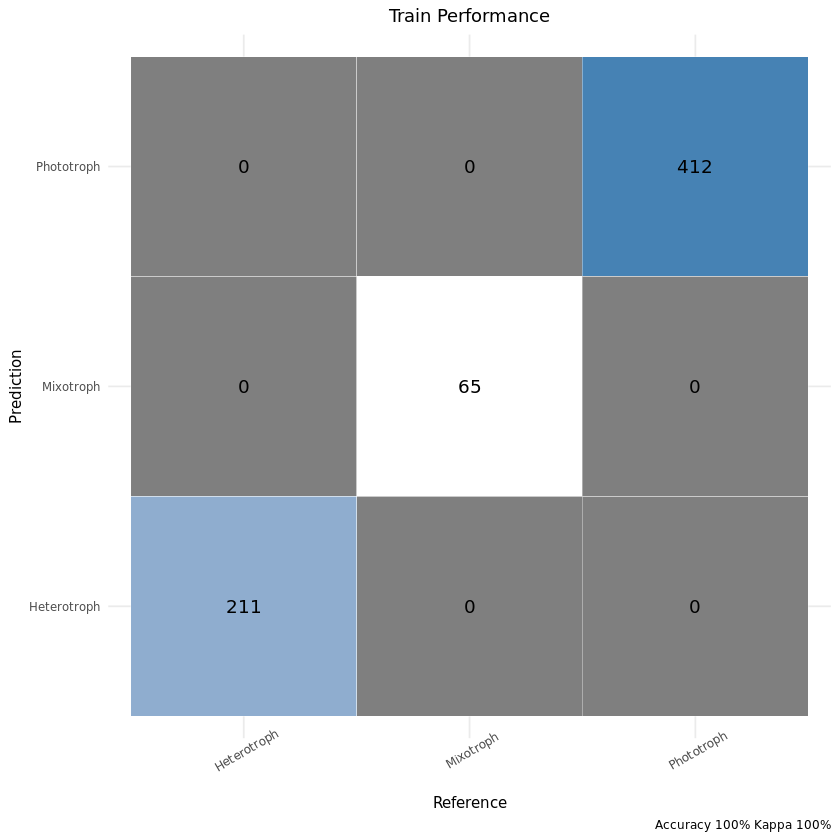

Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X1 = col_character()
)
ℹ Use `spec()` for the full column specifications.





Heterotroph   Mixotroph  Phototroph 
        709           0         286 

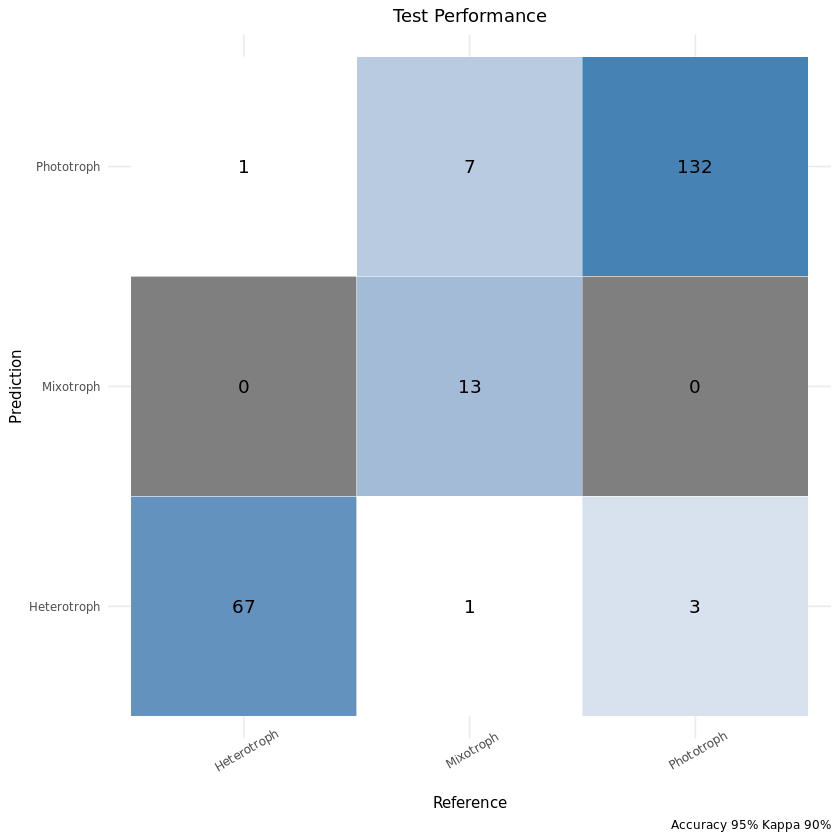

In [11]:
##### EVALUATE RF MODEL ON TEST DATA #####

# extract model parameters and use to build an optimal RF

# use model parameters to build optimized RF
train_filt <- (train_rows %>% dplyr::select(starts_with("K") & !starts_with("Ke")))[ , vita$var]
train_filt$trophic <- as.factor(train_rows$Trophic.mode)
optimal_rf <- ranger(
  dependent.variable.name = "trophic",
  mtry            = recommended_pars$mtry,
  num.trees       = 10000,
  data            = train_filt,
  sample.fraction = recommended_pars$sample.fraction,
  min.node.size   = recommended_pars$min.node.size,
  seed            = 1,
  importance      = 'impurity'
)

saveRDS(optimal_rf, file = file.path("..","..","output",
                                     paste0("optimal_rf_seed1_",as.character(Sys.Date()),
                                            "_rand.RDS")))

evaluate_model(optimal_ranger = optimal_rf,
               data = train_filt, reference_class = as.factor(train_filt$trophic),
               plt_title = "Train Performance")

##### EVALUATE MODEL ON UNKNOWN MAGS #####
test_rows = test_rows %>% arrange(Source_ID)
test_filt <- (test_rows %>% dplyr::select(starts_with("K") & !starts_with("Ke")))[ , vita$var]
test_filt$trophic <- test_rows$Trophic.mode

evaluate_model(optimal_ranger = optimal_rf,
               data = test_filt, reference_class = as.factor(test_filt$trophic),
               plt_title = "Test Performance")

# run the model to predict trophic level of unknown mags ------------------
mags_unknown <- read_csv(file.path("..","..","input","MAG_keggannot.csv"))

mags_unknown <- mags_unknown %>%
  select(X1, all_of(vita$var)) %>%
  as.data.frame() %>%
  column_to_rownames("X1")

pred <- predict(optimal_rf, mags_unknown)
table(pred$predictions)

**Look at the output of the Burns model in the context of all the output from the MMETSP**

In [12]:
##### CALCULATE HETEROTROPHY INDEX SCORES #####
training_scores = generate_scores_selected_features(train_rows, vita$var)
listed_outputs = classify_points_binom(mmetsp_allfeatures_test, training_scores, "Source_ID")
score_matrix = listed_outputs[[1]]
predicted_by_heterotrophyindex = listed_outputs[[2]]
predicted_by_maxscore = listed_outputs[[3]]

`summarise()` regrouping output by 'Trophic.mode' (override with `.groups` argument)

`summarise()` regrouping output by 'Trophic.mode' (override with `.groups` argument)



In [13]:
##### READ IN BURNS MODEL OUTPUT FROM THE MMETSP #####
burns_mmetsp = data.frame(fread("burns_model_MMETSP.txt",sep="\t"))

In [14]:
burns_mmetsp["MMETSP_ID"] = sapply(strsplit(as.character(burns_mmetsp$Genome),"\\."), `[`, 1)

In [37]:
mmetsp_validation = mmetsp_allfeatures_test
mmetsp_validation$RF.predicted.TM = predict(optimal_rf, mmetsp_allfeatures_test)$predictions
burns_combined = predicted_by_heterotrophyindex %>% 
    dplyr::right_join(burns_mmetsp, by=c("Source_ID"="MMETSP_ID")) %>% 
    dplyr::left_join(mmetsp_validation %>% dplyr::select(Source_ID, Trophic.mode, RF.predicted.TM)) %>%
    dplyr::filter(!is.na(Trophic.mode))

Joining, by = c("Source_ID", "RF.predicted.TM")



In [38]:
predict(optimal_rf, mmetsp_allfeatures_test)

Ranger prediction

Type:                             Classification 
Sample size:                      642 
Number of independent variables:  1787 

In [39]:
nrow(burns_combined %>% dplyr::filter(RF.predicted.TM != Trophic.mode) %>% 
    dplyr::select(HeterotrophyScore,Predicted.trophic.mode,RF.predicted.TM,
                  Photosynthesis.prediction,Trophic.mode))
nrow(burns_combined)

Adding missing grouping variables: `Source_ID`



[1] 5

[1] 379

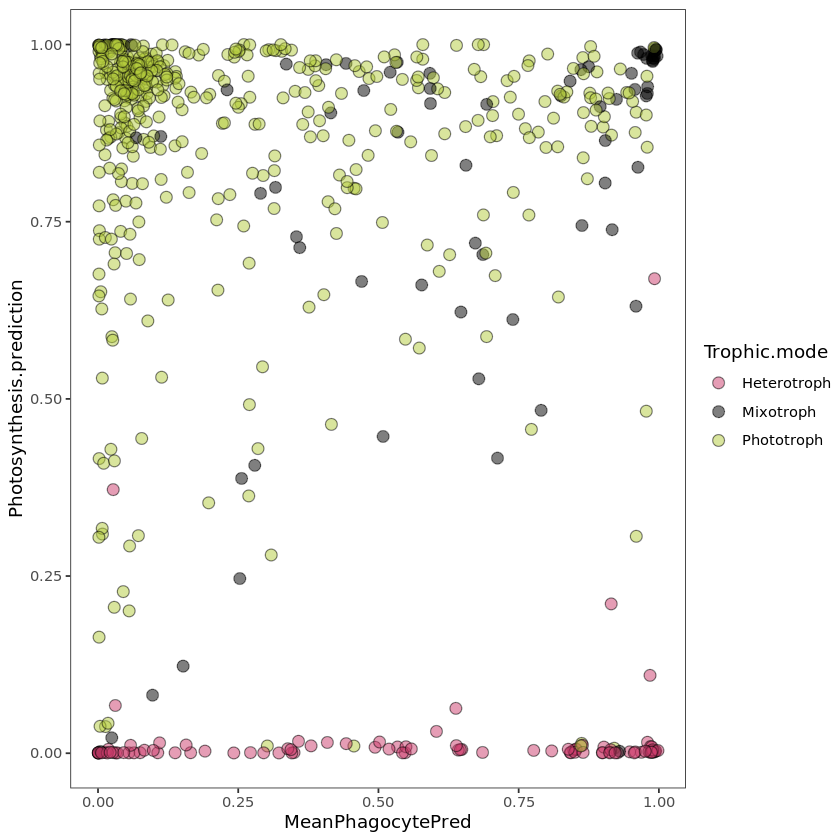

In [17]:
burns_combined = burns_combined %>% dplyr::mutate("MeanPhagocytePred" = (Phagocyte.generalist.prediction + 
                                 Phagocyte.entamoebid.prediction +
                                 Phagocyte.rozellid.prediction) / 3)
ggplot(burns_combined) + geom_point(aes(x=MeanPhagocytePred,
                                        y=Photosynthesis.prediction,fill = Trophic.mode),pch=21,col="black",
                                   size=3,alpha=0.5) + 
    scale_fill_manual(values=c("#CC3D6D","black","#B4CC3D"),breaks=c("Heterotroph","Mixotroph","Phototroph")) + 
    theme_test()

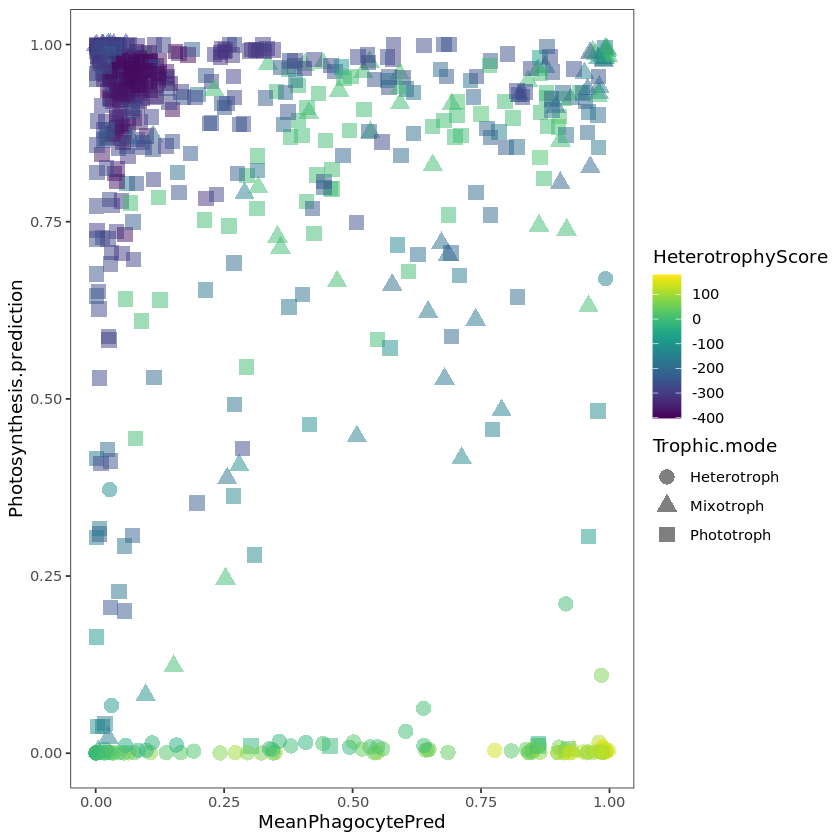

In [18]:
ggplot(burns_combined) + geom_point(aes(x=MeanPhagocytePred,
                                        y=Photosynthesis.prediction,shape = Trophic.mode,
                                        col=HeterotrophyScore),
                                   size=4,alpha=0.5) + 
    scale_color_viridis() +
    theme_test()

In [19]:
burns_combined = burns_combined %>% mutate(PhagoBin = cut(MeanPhagocytePred, breaks = c(0,0.25,0.5,0.75,1)),
                          PhotoBin = cut(Photosynthesis.prediction, breaks = c(0,0.25,0.5,0.75,1)),
                                         PhagoGeneralBin = cut(Phagocyte.generalist.prediction, breaks = c(0,0.25,0.5,0.75,1)))
combined_metrics = burns_combined %>% dplyr::select(MeanPhagocytePred,Photosynthesis.prediction,
                                                    Prototrophy.prediction,Trophic.mode,Source_ID,
                                                    Phagocyte.generalist.prediction) %>% 
                    reshape2::melt(id.vars=c("Trophic.mode","Source_ID")) 

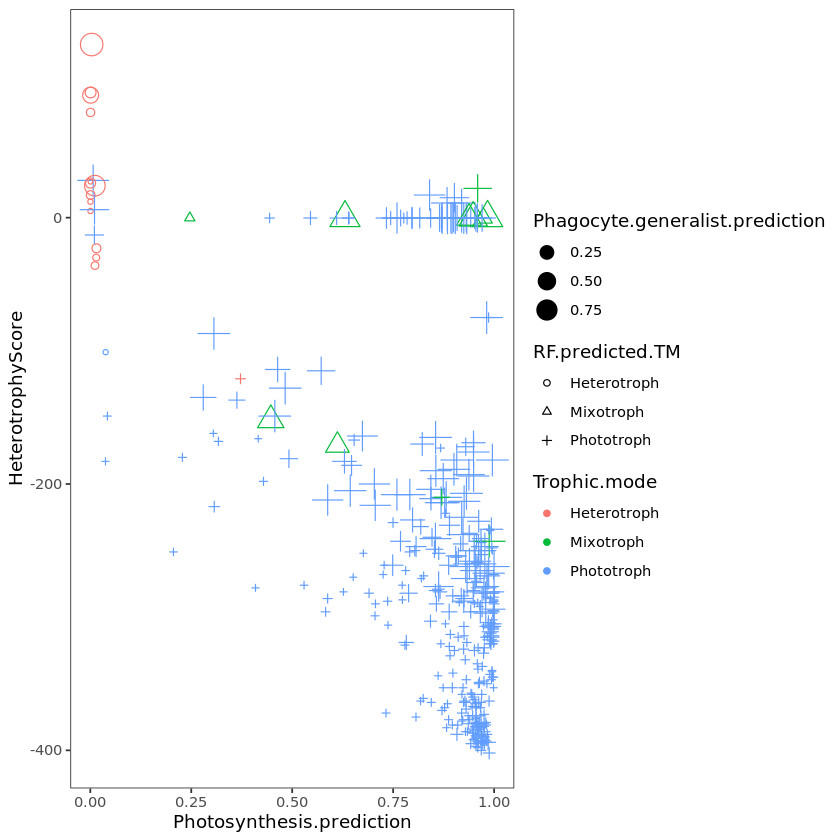

In [33]:
ggplot(burns_combined) + geom_point(aes(x=Photosynthesis.prediction,
                                        y=HeterotrophyScore,color=Trophic.mode,
                                        shape=RF.predicted.TM,size=Phagocyte.generalist.prediction)) +
    scale_shape_manual(values=c(1,2,3)) + 
    theme_test()

`summarise()` regrouping output by 'Trophic.mode', 'PhagoBin' (override with `.groups` argument)



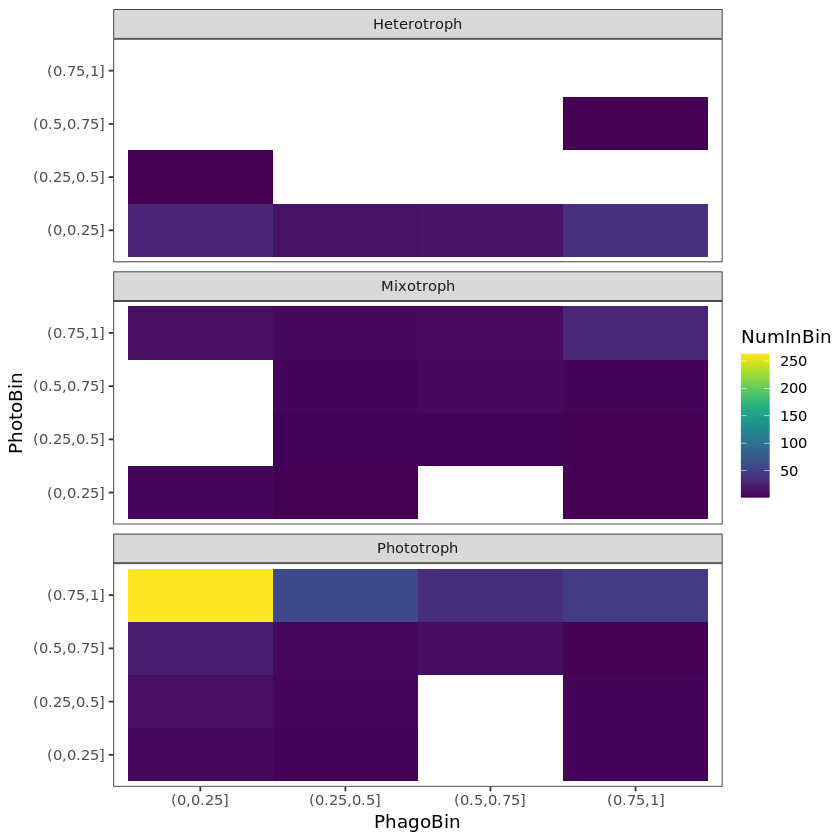

In [51]:
burns_binned = burns_combined %>% dplyr::group_by(Trophic.mode,PhagoBin,PhotoBin) %>% 
    dplyr::summarize(MeanHeterotrophy = mean(HeterotrophyScore), NumInBin = n())
ggplot(burns_binned) + geom_tile(aes(x = PhagoBin,y=PhotoBin, fill = NumInBin)) + 
    facet_wrap(~Trophic.mode,ncol=1) + theme_test() + scale_fill_viridis()

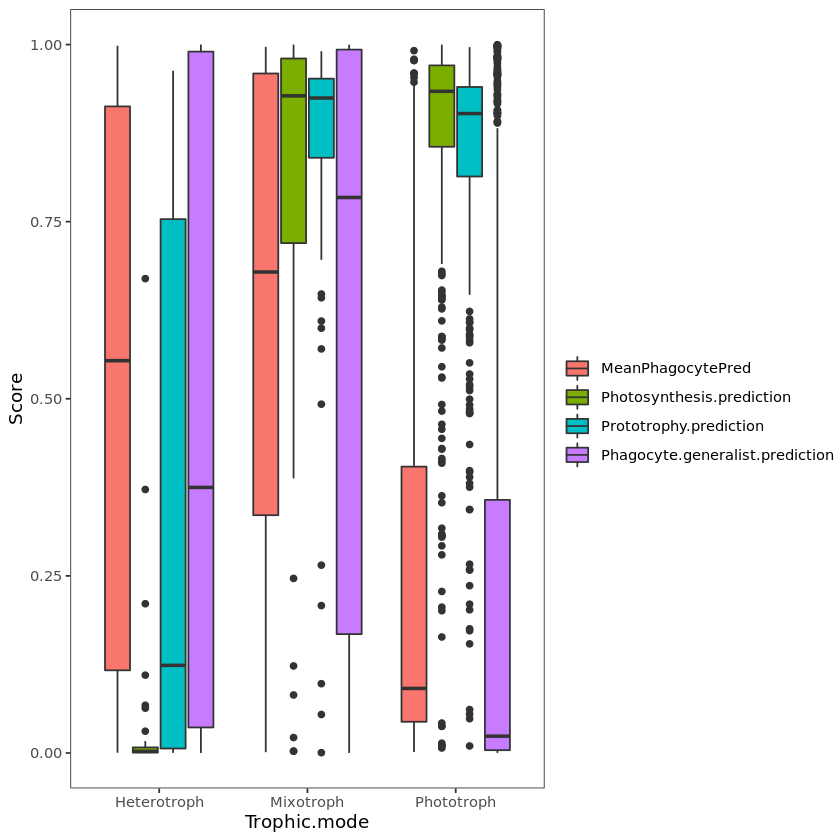

In [112]:
ggplot(combined_metrics,aes(x=Trophic.mode,fill=variable,y=value)) + 
    geom_boxplot() + theme_test() + scale_fill_discrete(name="") + ylab("Score")

In [19]:
all_tax_info = mmetsp_allfeatures %>% dplyr::mutate(Name_to_Use = Source_ID) %>% dplyr::bind_rows(eukprot_withtax)
sagenista_ciliophora = all_tax_info %>% dplyr::filter((Division == "Ciliophora") | (Division == "Sagenista"))

In [20]:
sagenista_ciliophora_vita = (sagenista_ciliophora %>% dplyr::select(starts_with("K") & !starts_with("Ke")))[ , vita$var]
pred_sag <- predict(optimal_rf, sagenista_ciliophora_vita)
table(pred_sag$predictions)


Heterotroph   Mixotroph  Phototroph 
         45           1           0 

In [22]:
sagenista_selected = (sagenista_ciliophora %>% dplyr::select(starts_with(c("K","Name_to_Use"))) %>%
     dplyr::select(!starts_with("Ke")))[ , c(vita$var,"Name_to_Use")]

In [23]:
##### CALCULATE HETEROTROPHY INDEX SCORES #####
listed_outputs = classify_points_binom(sagenista_selected, training_scores, "Name_to_Use")
score_matrix_sag = listed_outputs[[1]]
predicted_by_heterotrophyindex_sag = listed_outputs[[2]]
predicted_by_maxscore_sag = listed_outputs[[3]]

In [26]:
predicted_by_heterotrophyindex_sag$Predicted.trophic.mode.rf = as.character(pred_sag$predictions)
predicted_by_heterotrophyindex_trop = predicted_by_heterotrophyindex_sag %>% 
    dplyr::left_join(all_tax_info,by=c("Source_ID"="Name_to_Use")) %>% 
    dplyr::select(c(colnames(predicted_by_heterotrophyindex_sag),"Division","Trophic.mode"))

In [27]:
predicted_by_heterotrophyindex_trop

Source_ID,HeterotrophyScore,Predicted.trophic.mode,Predicted.trophic.mode.rf,Division,Trophic.mode
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
Ichthyophthirius_multifilii,111,Heterotroph,Heterotroph,Ciliophora,Heterotroph
MMETSP0123,55,Heterotroph,Heterotroph,Ciliophora,Heterotroph
MMETSP0125,60,Heterotroph,Heterotroph,Ciliophora,Heterotroph
MMETSP0126,20,Heterotroph,Heterotroph,Ciliophora,Heterotroph
MMETSP0127,117,Heterotroph,Heterotroph,Ciliophora,Heterotroph
MMETSP0198,7,Heterotroph,Heterotroph,Sagenista,Heterotroph
MMETSP0199,2,Mixotroph,Heterotroph,Sagenista,Heterotroph
MMETSP0205,28,Heterotroph,Heterotroph,Ciliophora,Heterotroph
MMETSP0206,45,Heterotroph,Heterotroph,Ciliophora,Heterotroph


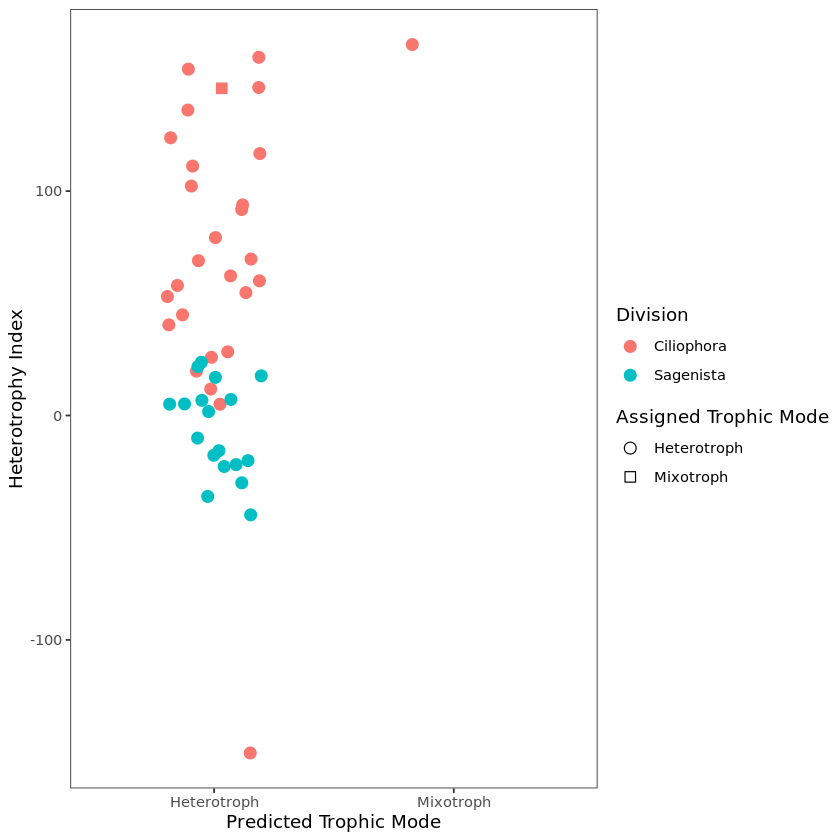

In [30]:
ggplot(predicted_by_heterotrophyindex_trop) + 
    geom_jitter(aes(x = Predicted.trophic.mode.rf, y = HeterotrophyScore, fill = Division,
                    shape = Trophic.mode, col = Division),
                size=3,width=0.2) + 
    scale_shape_manual(values=c(21,22), name = "Assigned Trophic Mode") + 
    theme_test() + xlab("Predicted Trophic Mode") + ylab("Heterotrophy Index")
ggsave("ciliophora_sagenista.png",width=5,height=5,units="in")

In [31]:
##### FILTER MAGS BY BUSCO COMPLETENESS #####
busco_completeness = read.csv(file.path("..","..","input","EUK_BUSCO_CC.csv"))
colnames(busco_completeness) = c("MAGs","Completeness","Contamination")
complete_MAGs <- busco_completeness$MAGs[busco_completeness$Completeness > 30]

listed_outputs_mags = classify_points_binom(mags_unknown%>%dplyr::mutate(MAGs=rownames(.)), 
                                            training_scores, "MAGs")
score_matrix = listed_outputs_mags[[1]]
predicted_by_heterotrophyindex = listed_outputs_mags[[2]]
predicted_by_maxscore = listed_outputs_mags[[3]]

combo_for_plot = mags_unknown %>% 
                dplyr::mutate(MAGs=rownames(.)) %>% 
                dplyr::inner_join(predicted_by_heterotrophyindex,by=c("MAGs"="Source_ID"))

mag_info = data.frame("MAGs" = combo_for_plot$MAGs, "PredictedTrophicMode" = pred$predictions,
                      "HeterotrophyScore" = combo_for_plot$HeterotrophyScore) %>%
    dplyr::filter(MAGs %in% complete_MAGs) 

In [32]:
##### FILTER MAGS BY BUSCO COMPLETENESS #####
busco_completeness = read.csv(file.path("..","..","input","EUK_BUSCO_CC.csv"))
colnames(busco_completeness) = c("MAGs","Completeness","Contamination")
complete_MAGs <- busco_completeness$MAGs[busco_completeness$Completeness > 30]

listed_outputs_mags = classify_points_binom(mags_unknown%>%dplyr::mutate(MAGs=rownames(.)), 
                                            training_scores, "MAGs")
score_matrix = listed_outputs_mags[[1]]
predicted_by_heterotrophyindex = listed_outputs_mags[[2]]
predicted_by_maxscore = listed_outputs_mags[[3]]

combo_for_plot = mags_unknown %>% 
                dplyr::mutate(MAGs=rownames(.)) %>% 
                dplyr::inner_join(predicted_by_heterotrophyindex,by=c("MAGs"="Source_ID"))

mag_info = data.frame("MAGs" = combo_for_plot$MAGs, "PredictedTrophicMode" = pred$predictions,
                      "HeterotrophyScore" = combo_for_plot$HeterotrophyScore) %>%
    dplyr::filter(MAGs %in% complete_MAGs) 

##### READ IN METADATA AND TPM MATRIX #####
datamatrix = read.csv(file.path("/vortexfs1","omics","alexander","halexander","2020-tara-mag-abund",
                                      "MAG_tpm.csv"))
environmental_metadata = read.csv(file.path("..","..","input","PRJEB4352_metaG_wenv_PE.txt"),sep="\t")
data_mat_trans = data.frame(t(datamatrix)) %>% rownames_to_column("run_accession")
colnames(data_mat_trans)[2:ncol(data_mat_trans)] = as.character(datamatrix$Genome)
metadata_merged = environmental_metadata %>% dplyr::inner_join(data_mat_trans, by = c("run_accession"))
enviro_long = metadata_merged %>% pivot_longer(cols = as.character(datamatrix$Genome), 
                                 names_to="Genome", values_to="Abundance")

In [16]:
##### CALCULATE PCA ON MAG DATA #####
dist <- vegdist(mags_unknown %>% 
                dplyr::filter(rownames(.) %in% complete_MAGs) %>% 
                mutate_all(as.numeric),  method = "jaccard")
res.pca <- prcomp(dist, scale = TRUE)
PCinfo = data.frame(res.pca$x)


In [17]:
##### COMBINE ALL MAG INFORMATION #####

mag_info_class =  mag_info %>% 
    dplyr::mutate(Classifications = get_euk_prok(mag_info$MAGs)$classification) %>%
    separate(Classifications, sep = ";", fill = "left",
                    c("Domain","Supergroup","Phylum","Class",
                             "Order","Family","Genus","Species")) 

results_PCA = data.frame("MAGs" = mag_info$MAGs) %>% 
    dplyr::mutate(PC1 = PCinfo$PC1,PC2 = PCinfo$PC2) %>%
    dplyr::inner_join(mag_info,by="MAGs")

In [ ]:
##### VISUALIZATIONS #####

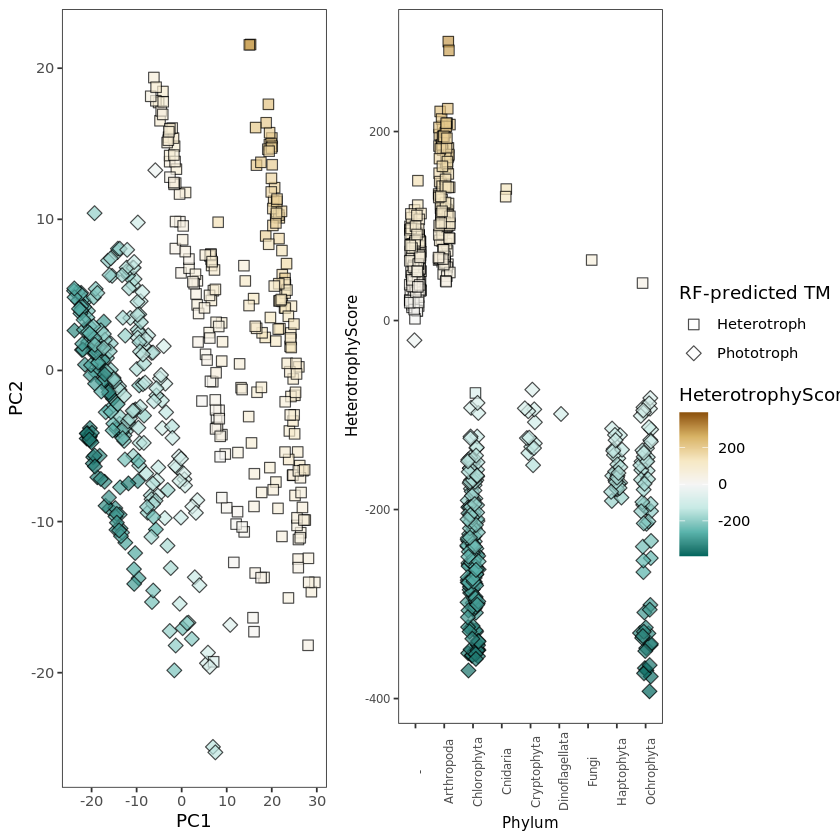

In [21]:
pacman::p_load(cowplot)
limit <- max(abs(results_PCA$HeterotrophyScore)) * c(-1, 1)
pca_plot = ggplot(results_PCA) + geom_point(aes(x=PC1,y=PC2,
                                     shape=PredictedTrophicMode,
                                     fill=HeterotrophyScore),color="black",size=3,alpha=0.7) + 
    scale_shape_manual(name="RF-predicted TM", values = c(22,23,24)) + 
  scale_fill_distiller(type = "div", limit = limit) + 
    theme_test()
legend_all = get_legend(pca_plot)
classification_plot = ggplot(mag_info_class) + 
    geom_jitter(aes(x=Phylum,shape=PredictedTrophicMode,
                    y=HeterotrophyScore, fill = HeterotrophyScore),
                color="black",size=3,alpha=0.7,width=0.2) + 
    scale_shape_manual(name="RF-predicted TM", values = c(22,23,24)) +  
    theme_test() + 
    scale_fill_distiller(type = "div", limit = limit) + 
    theme(legend.position = "none", 
          text = element_text(size = 9),
          axis.text.x = element_text(angle = 90, vjust = 1),
          axis.text = element_text(size = 7),
          plot.title = element_text(hjust = 0.5))
cowplot::plot_grid(pca_plot+theme(legend.position="none"),
                   classification_plot+theme(legend.position="none"),
                  legend_all,rel_widths=c(1,1,0.5),ncol=3)
ggsave("pca_plusheterotrophy.png",width=10,height=6,units="in",dpi=400)

In [ ]:
##### PROCESSING ENVIRONMENTAL METADATA (LAT/LON) #####
pacman::p_load("cowplot", "googleway", "ggplot2", "ggrepel", 
               "ggspatial", "libwgeom", "sf", "rnaturalearth", "rnaturalearthdata")

enviro_merged = enviro_long %>% dplyr::inner_join(mag_info_class, by = c("Genome"="MAGs"))
depth_compare = enviro_merged %>% 
    dplyr::mutate(TPMWeightedHeterotrophy = as.numeric(as.character(Abundance)) * HeterotrophyScore) %>%
    dplyr::mutate(DepthCat = ntile(Depth..nominal, 6),DepthRange = cut_interval(Depth..nominal, n = 6)) %>% 
    dplyr::select(Depth..nominal,DepthCat,DepthRange,HeterotrophyScore)

summarized_stations = enviro_merged %>% 
    dplyr::mutate(TPMWeightedHeterotrophy = as.numeric(as.character(Abundance)) * HeterotrophyScore) %>%
    dplyr::mutate(DepthRange = cut(Depth..nominal,
        breaks = c(0,as.character(quantile(enviro_merged$Depth..nominal, c(0.5,0.6,0.75,0.9,0.95,1)))))) %>%
    dplyr::group_by(Longitude..of.the.geographic.coordinate.....,Latitude..of.the.geographic.coordinate.....,
                    DepthRange,Depth..nominal) %>% 
    dplyr::summarize(MeanTPMHeterotrophy = mean(TPMWeightedHeterotrophy))

In [ ]:
##### VISUALIZE ENVIRONMENTAL METADATA #####
world <- ne_countries(scale = "medium", returnclass = "sf")
heterotrophy_global = ggplot(data = world) + theme_bw() + 
    geom_sf(color = "black", fill = "gray") + 
    geom_jitter(data=summarized_stations, 
               aes(x = Longitude..of.the.geographic.coordinate.....,
                   y = Latitude..of.the.geographic.coordinate.....,
                   fill = MeanTPMHeterotrophy), alpha = 0.3, pch=21, width = 3) + 
    geom_point(data = summarized_stations %>% dplyr::filter(MeanTPMHeterotrophy > 255386.3),
              aes(x = Longitude..of.the.geographic.coordinate.....,
                   y = Latitude..of.the.geographic.coordinate.....,
                   fill = MeanTPMHeterotrophy), shape = "*", size = 4) +
    facet_wrap(~DepthRange) + 
    scale_fill_gradientn(colors = c("blue","yellow","orange","red"), name = "TPM-Weighted H-score") + 
    xlab("") + ylab("")
heterotrophy_global
ggsave("heterotrophy_global.png",width=10,height=6,units="in",dpi=400)

In [33]:
##### READ IN AND PROCESS BURNS MODEL RESULTS #####
burns_output = read.csv(file.path("..","..","input","ptm_Burns_output.tsv"),sep="\t")
burns_output_named = burns_output %>% tidyr::separate(Genome,into=c("MAGName","HMMinfo"),sep="\\.")
busco_completeness = read.csv(file.path("..","..","input","EUK_BUSCO_CC.csv"))
colnames(busco_completeness) = c("MAGs","Completeness","Contamination")

complete_MAGs <- busco_completeness$MAGs[busco_completeness$Completeness > 30]
burns_output_named = burns_output_named %>% dplyr::filter(MAGName %in% complete_MAGs) %>%
                        dplyr::mutate(Taxonomy=get_euk_prok(MAGName)$classification) %>%
                        separate(Taxonomy, sep = ";", fill = "left",
                                 c("Domain","Supergroup","Phylum","Class",
                                   "Order","Family","Genus","Species")) 

Warning message:
“Expected 2 pieces. Additional pieces discarded in 995 rows [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, ...].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 3 rows [1, 140, 485].”


In [34]:
head(burns_output_named)

,MAGName,HMMinfo,Phagocyte.generalist.prediction,Phagocyte.entamoebid.prediction,Phagocyte.rozellid.prediction,Prototrophy.prediction,Photosynthesis.prediction,Domain,Supergroup,Phylum,Class,Order,Family,Genus,Species
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,IO-all-DCM-0-8-5-00_bin-104,x,0.93373179,0.495987694,0.7570036,0.6248311,0.535923135,Eukaryota,Hacrobia,Cryptophyta,Cryptophyceae,Cryptomonadales,-,-,-
2,IO-all-DCM-0-8-5-00_bin-111,x,0.92894893,0.962047667,0.4779954,0.8015032,0.715404745,Eukaryota,Hacrobia,Haptophyta,Prymnesiophyceae,-,-,-,-
3,IO-all-DCM-0-8-5-00_bin-12,x,0.99470130,0.974080566,0.8969910,0.8620129,0.591672747,Eukaryota,Hacrobia,Haptophyta,Prymnesiophyceae,-,-,-,-
4,IO-all-DCM-0-8-5-00_bin-120,x,0.01517808,0.004762661,0.1311424,0.9185766,0.999249180,Eukaryota,Archaeplastida,Chlorophyta,Mamiellophyceae,Mamiellales,Mamiellaceae,Micromonas,Micromonas sp.
5,IO-all-DCM-0-8-5-00_bin-157,x,0.99383302,0.996793283,0.9739918,0.2657302,0.004353995,Eukaryota,-,-,-,-,-,-,-
6,IO-all-DCM-0-8-5-00_bin-17,x,0.02702141,0.120605234,0.2971786,0.8109665,0.951543522,Eukaryota,Archaeplastida,Chlorophyta,-,-,-,-,-


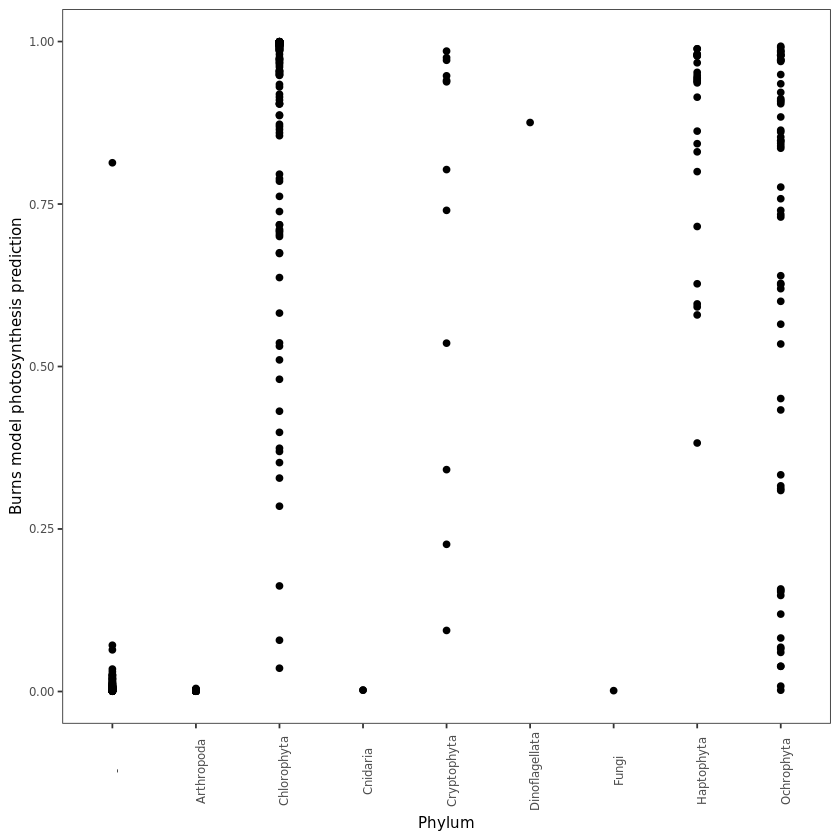

In [95]:
##### VISUALIZE BURNS MODEL OUTPUT WITH TAXONOMY #####
ggplot(burns_output_named) + geom_point(aes(x = Phylum, y = Photosynthesis.prediction)) + theme_test() + 
    theme(legend.position = "none", 
          text = element_text(size = 9),
          axis.text.x = element_text(angle = 90, vjust = 1),
          axis.text = element_text(size = 7),
          plot.title = element_text(hjust = 0.5)) + 
    ylab("Burns model photosynthesis prediction")

In [22]:
##### VISUALIZE BURNS MODEL OUTPUT WITH HETEROTROPHY SCORE #####
heterotrophy_merged = mag_info_class %>% dplyr::left_join(burns_output_named,
                                                          by=c("MAGs" = "MAGName","Phylum",
                                                               "Class","Order","Family","Genus",
                                                               "Species","Domain","Supergroup"))
photsyn_heterotrophy_phylum = ggplot(heterotrophy_merged) + 
    geom_jitter(aes(x = Phylum, y = Photosynthesis.prediction,
                                            fill = HeterotrophyScore,
                                            shape = PredictedTrophicMode),
                                          width=0.3, size=2, alpha=0.5) + theme_test() + 
    scale_shape_manual(name="RF-predicted TM", values = c(22,23,24)) +  
    scale_fill_distiller(type = "div", limit = limit) + 
    theme(text = element_text(size = 9),
          axis.text.x = element_text(angle = 90, vjust = 1),
          axis.text = element_text(size = 7),
          plot.title = element_text(hjust = 0.5)) + 
    ylab("Burns model photosynthesis prediction")

In [26]:
write.csv(heterotrophy_merged %>% dplyr::select(MAGs, PredictedTrophicMode, HeterotrophyScore,
                                      Prototrophy.prediction,Photosynthesis.prediction,
                                      Phagocyte.rozellid.prediction,Phagocyte.generalist.prediction),
          file.path("..","..","output","fortree_10Mar2021.csv"), row.names=FALSE)

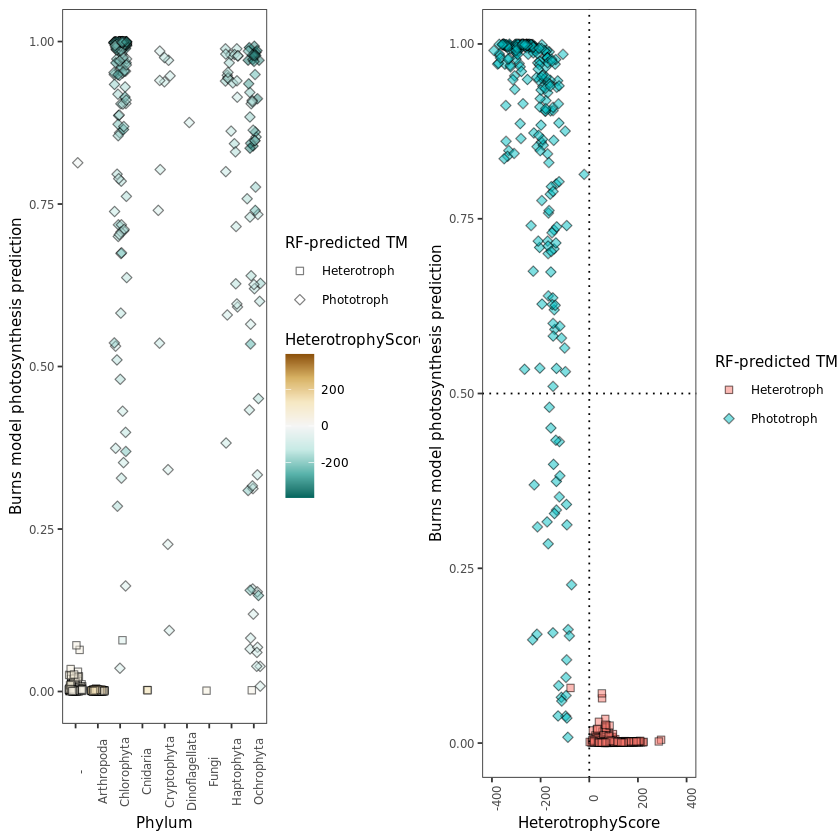

In [104]:
photosyn_prediction <- ggplot(heterotrophy_merged) + geom_jitter(aes(y = Photosynthesis.prediction,
                                              fill = PredictedTrophicMode,
                                              x = HeterotrophyScore,
                                              shape = PredictedTrophicMode),
                                          width=0.3, size=2, alpha=0.5) + theme_test() + 
    scale_shape_manual(name="RF-predicted TM", values = c(22,23,24)) +  
    scale_fill_discrete(name="RF-predicted TM") +  
    theme(text = element_text(size = 9),
          axis.text.x = element_text(angle = 90, vjust = 1),
          axis.text = element_text(size = 7),
          plot.title = element_text(hjust = 0.5)) + 
    xlim(-400,400) + 
    geom_vline(aes(xintercept=0),linetype="dotted") + 
    geom_hline(aes(yintercept=0.5),linetype="dotted") + 
    ylab("Burns model photosynthesis prediction")
cowplot::plot_grid(photsyn_heterotrophy_phylum,photosyn_prediction)
ggsave("burns_model.png",width=12,height=6,units="in",dpi=400)

Saving 6.67 x 6.67 in image



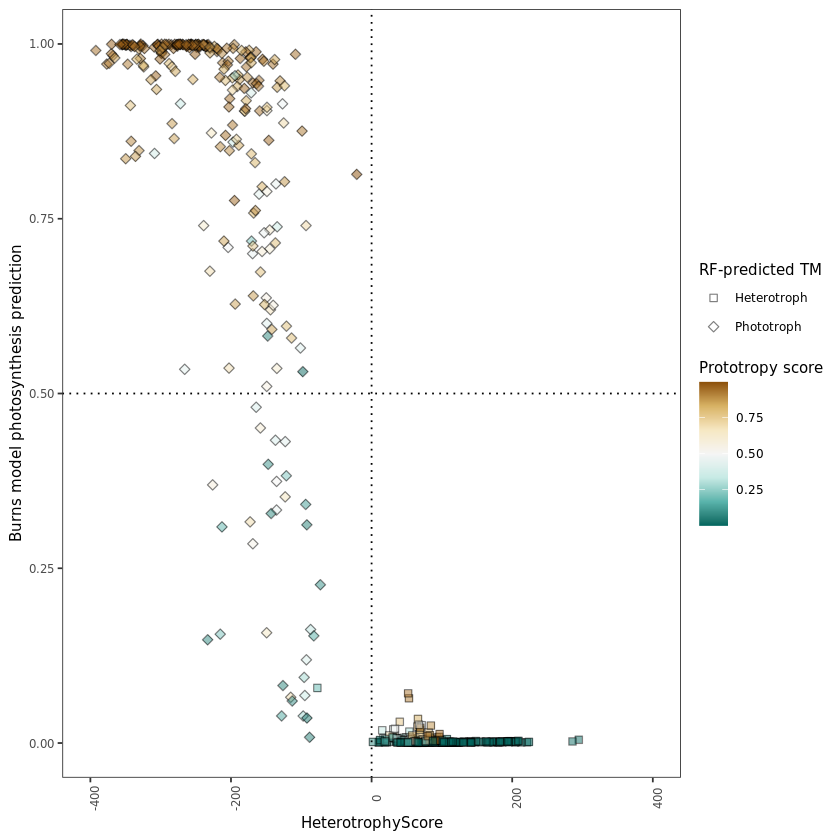

In [105]:
ggplot(heterotrophy_merged) + geom_jitter(aes(y = Photosynthesis.prediction,
                                              fill = Prototrophy.prediction,
                                              x = HeterotrophyScore,
                                              shape = PredictedTrophicMode),
                                          width=0.3, size=2, alpha=0.5) + theme_test() + 
    scale_shape_manual(name="RF-predicted TM", values = c(22,23,24)) +  
    scale_fill_distiller(type = "div", name = "Prototropy score") +
    theme(text = element_text(size = 9),
          axis.text.x = element_text(angle = 90, vjust = 1),
          axis.text = element_text(size = 7),
          plot.title = element_text(hjust = 0.5)) + 
    xlim(-400,400) + 
    geom_vline(aes(xintercept=0),linetype="dotted") + 
    geom_hline(aes(yintercept=0.5),linetype="dotted") + 
    ylab("Burns model photosynthesis prediction")
ggsave("burns_model_prototrophy.png",dpi=400)

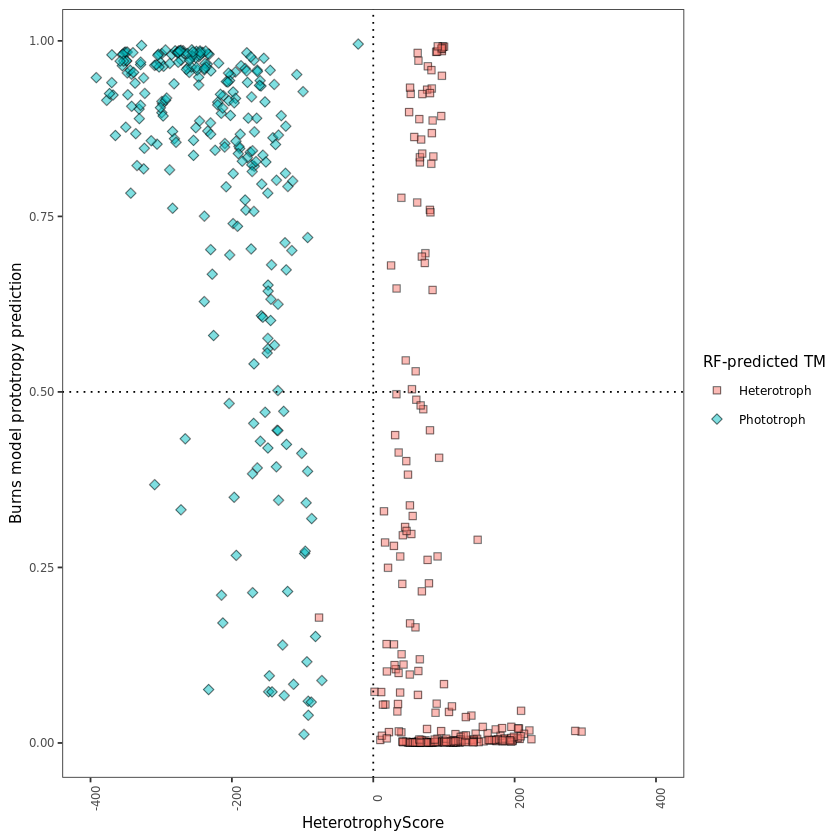

In [78]:
ggplot(heterotrophy_merged) + geom_jitter(aes(y = Prototrophy.prediction,
                                              fill = PredictedTrophicMode,
                                              x = HeterotrophyScore,
                                              shape = PredictedTrophicMode),
                                          width=0.3, size=2, alpha=0.5) + theme_test() + 
    scale_shape_manual(name="RF-predicted TM", values = c(22,23,24)) +  
    scale_fill_discrete(name="RF-predicted TM") +  
    theme(text = element_text(size = 9),
          axis.text.x = element_text(angle = 90, vjust = 1),
          axis.text = element_text(size = 7),
          plot.title = element_text(hjust = 0.5)) + 
    xlim(-400,400) + 
    geom_vline(aes(xintercept=0),linetype="dotted") + 
    geom_hline(aes(yintercept=0.5),linetype="dotted") + 
    ylab("Burns model prototropy prediction")